## Import statements

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt


In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/haran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Getting the Dataset

In [3]:
test_path = "../data/test.csv"
train_path = "../data/train.csv"

### Specifying the device  that's resposnible for loading a tensor into memory

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Importing the dataset

In [5]:
train_df = pd.read_csv(train_path, on_bad_lines='skip')
train_df

,Id,Category,Tweet
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...
...,...,...,...
5965,639016598477651968,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
5966,640276909633486849,neutral,Rib injury for Zlatan against Russia is a big ...
5967,640296841725235200,neutral,Noooooo! I was hoping to see Zlatan being Zlat...
5968,641017384908779520,neutral,Not Available


In [6]:
test_df = pd.read_csv(test_path, on_bad_lines='skip')
test_df

,Id,Category
0,6.289494e+17,dear @Microsoft the newOoffice for Mac is grea...
1,6.289766e+17,@Microsoft how about you make a system that do...
2,6.290232e+17,Not Available
3,6.291792e+17,Not Available
4,6.291863e+17,If I make a game as a #windows10 Universal App...
...,...,...
9963,NaN,NaN
9964,NaN,NaN
9965,NaN,NaN
9966,NaN,NaN


# Data Pre-Processing

### First we clean up the training data.
-> We get rid of the "Id" column as its not useful for our model 


-> We then remove all the Null values in our data

In [7]:
train_df = train_df.drop(columns=["Id"])
train_df = train_df.dropna()
train_df = train_df[train_df["Tweet"] != "Not Available"]
train_df

,Category,Tweet
1,neutral,IOS 9 App Transport Security. Mm need to check...
2,neutral,"Mar if you have an iOS device, you should down..."
3,negative,@jimmie_vanagon my phone does not run on lates...
4,positive,Not sure how to start your publication on iOS?...
5,neutral,"Two Dollar Tuesday is here with Forklift 2, Qu..."
...,...,...
5963,positive,"Ok ed let's do this, Zlatan, greizmann and Lap..."
5964,neutral,Goal level: Zlatan 90k by Friday? = Posting e...
5965,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
5966,neutral,Rib injury for Zlatan against Russia is a big ...


### Now we will look at the test data

-> We rename the category column to tweets

-> And then we apply the same steps as above

In [8]:
test_df = test_df.rename(columns={"Category":"Tweet"})

In [9]:
test_df = test_df.drop(columns=["Id"])
test_df = test_df.dropna()
test_df = test_df[test_df["Tweet"] != "Not Available"]
test_df

,Tweet
0,dear @Microsoft the newOoffice for Mac is grea...
1,@Microsoft how about you make a system that do...
4,If I make a game as a #windows10 Universal App...
5,"Microsoft, I may not prefer your gaming branch..."
6,@MikeWolf1980 @Microsoft I will be downgrading...
...,...
3994,Anybody with a Steak &amp; Shake or IHOP move ...
3995,I am assembling an epic Pancake Posse for an I...
3996,do you work at Ihop tomorrow @carlysunshine_
3997,23 Aug 00;30 #771NAS Rescue193 returned from T...


### Dealing with the Class Imbalance

In [10]:
train_df['Category'].value_counts()

positive    2599
neutral     1953
negative     869
Tweet          1
Name: Category, dtype: int64

When we have surpervised datasets, the number of instances of each class needs to be balanced. An imbalance in the training set could skew our model and reduce its accurate. 

There are many methods that can be used to deal with this such as oversampling,undersampling and augmentation. In this case undersampling is used.

In undersampling we decrease the number of instances of the majority class. In this case we remove tweets from the neutral and positive classes until we end up with 869 tweets

In [11]:
neg_df = train_df[train_df["Category"] == "negative"]
pos_df = train_df[train_df["Category"] == "positive"]
neu_df = train_df[train_df["Category"] == "neutral"]

pos_drop = np.random.choice(pos_df.index,2599-869,replace=False)
neu_drop = np.random.choice(neu_df.index,1953-869,replace=False)

pos_undersampled = pos_df.drop(pos_drop)
neu_undersampled = neu_df.drop(neu_drop)

balanced_train_df = pd.concat([neg_df,neu_undersampled,pos_undersampled])

In [12]:
balanced_train_df

,Category,Tweet
3,negative,@jimmie_vanagon my phone does not run on lates...
29,negative,@_tomcc @bartwerf please stop walking and work...
36,negative,"@DeltaAssist yes, I asked an attendant to prin..."
91,negative,ok inbox on iOS has a pretty animation for the...
100,negative,Lost my iPad for the 2nd time today
...,...,...
5932,positive,Scenes when Benzema walks out of tunnel tomorr...
5940,positive,The VP of France's refereeing union Laurent Ug...
5945,positive,Reserving the right to put Milan 3rd if Zlatan...
5952,positive,"Mourinho, Zlatan, Serie A - who are the winner..."


In [13]:
balanced_train_df["Category"].value_counts()

negative    869
neutral     869
positive    869
Name: Category, dtype: int64

### Splitting the data into test and training sets

This has to be done as our test data is not labelled

In [14]:
train_b_df,test_b_df = train_test_split(balanced_train_df,test_size = 0.15)

In [15]:
train_b_df

,Category,Tweet
2849,neutral,"Tomorrow, I pray the Persian people will stand..."
4659,neutral,just another Monday without teen wolf
1958,positive,I'll be live streaming the sad Giants fans via...
3368,neutral,Space Mountain may be the oldest ride in the p...
4433,positive,I would do anything to see taylor swift in con...
...,...,...
5897,negative,Friend with connections just offered to let me...
1307,positive,"Residents say: ""It's a blessing this didn't ha..."
4436,negative,tomorrow is the taylor swift concert where i l...
3405,negative,@OpposingViews I hear it may only be 15. Rick ...


In [16]:
test_b_df

,Category,Tweet
1058,neutral,Juventus sign Inter midfielder Harnanes: Turin...
5778,negative,@XboxSupport abt time we got a reply from xbox...
4064,positive,Sony's 20th Anniversary sale going on now htt...
750,neutral,Someone see Jurassic park with me tomorrow
2459,neutral,It's tough going when you start watching a sho...
...,...,...
561,negative,Jeb Bush pretending he's a co front runner but...
243,positive,In Wednesday's #FirstFT - long reign the Queen...
5403,positive,"Tomorrow, on March 14th, one month after Valen..."
2204,negative,My 8yr old just back talked me.. On Monday whe...


#### Conversion of both dataframes to lists for easier manipulation. This can be done as the data size is relatively small

In [17]:
train_set = list(train_b_df.to_records(index=False))
test_set = list(test_b_df.to_records(index=False))

In [18]:
train_set[:5]

[('neutral', "Tomorrow, I pray the Persian people will stand with Trump in Washington and stop Obama's nuclear insanity."),
 ('neutral', 'just another Monday without teen wolf'),
 ('positive', "I'll be live streaming the sad Giants fans via @AppMeerkat this Saturday night at MetLife after @BBortles5 beats the Giants again. #JAXvsNYG"),
 ('neutral', 'Space Mountain may be the oldest ride in the park, BUT it has the longest line. Ric Flair http://t.co/gr38yiGwcT'),
 ('positive', 'I would do anything to see taylor swift in concert on the 18th')]

In [19]:
test_set[:5]

[('neutral', 'Juventus sign Inter midfielder Harnanes: Turin, Sep 1 : Italian football champions Juventus have bolstered the... http://t.co/bn03KmrtHv'),
 ('negative', '@XboxSupport abt time we got a reply from xbox 4 hours and counting, this is the 3rd time in a month what u doing to fix this issue xbox'),
 ('positive', "Sony's 20th Anniversary sale going on now  http://t.co/o98eV4BdyL"),
 ('neutral', 'Someone see Jurassic park with me tomorrow'),
 ('neutral', "It's tough going when you start watching a show on Netflix w/ 5+ seasons when it's only the 3rd week of classes &amp; can't afford to get behind")]

#### As we can see the tweets have to be cleaned, special symbols and links have to be removed

In [20]:
# We create a function to do the cleaning, which can then be applied on the list
def tweet_clean(tweet):
    link_pattern = "https?:\/\/t.co/[\w]+"
    mention_pattern = "@\w+"
    tweet = re.sub(link_pattern, "", tweet)
    tweet = re.sub(mention_pattern, "", tweet)
    return tweet.lower()

### Tokenization


Here we use the `word_tokenize()` function from the NLTK library to split the sentence into tokens or words

In [21]:
train_set = [(label,word_tokenize(tweet_clean(tweet))) for label,tweet in train_set]
train_set[:1]

[('neutral',
  ['tomorrow',
   ',',
   'i',
   'pray',
   'the',
   'persian',
   'people',
   'will',
   'stand',
   'with',
   'trump',
   'in',
   'washington',
   'and',
   'stop',
   'obama',
   "'s",
   'nuclear',
   'insanity',
   '.'])]

In [22]:
test_set = [(label,word_tokenize(tweet_clean(tweet))) for label,tweet in test_set]
test_set[:1]

[('neutral',
  ['juventus',
   'sign',
   'inter',
   'midfielder',
   'harnanes',
   ':',
   'turin',
   ',',
   'sep',
   '1',
   ':',
   'italian',
   'football',
   'champions',
   'juventus',
   'have',
   'bolstered',
   'the',
   '...'])]

### Now we have to form the vocabulary for the corpus, here we map each word in both the training and test set to a number

In [23]:
word_index = ["<PAD>","<SOS>","<EOS>"]

for pair in [train_set,test_set]:
    for label,tweet in pair:
        for token in tweet:
            if token not in word_index:
                word_index.append(token)
            



In [24]:
word_index[3]

'tomorrow'

In [25]:
word_index_dict = {token:index for index,token in enumerate(word_index)}

In [26]:
word_index_dict['very']

1207

#### Encoding the labels 

In [27]:
def label_map(label):
    if label == "negative":
        return 0
    elif label == "neutral":
        return 1
    else:
        return 2

#### As our model will take a fixed size tweet as input, we need to pad the tweets that are less than the specified tweet length, and truncate the tweets that are larger

In [59]:
seq_length = 32

In [60]:
def encode_and_pad(tweet,length):
    
    sos = [word_index_dict["<SOS>"]]
    eos = [word_index_dict["<EOS>"]]
    pad = [word_index_dict["<PAD>"]]
    
    if len(tweet) < length - 2: # -2 for SOS and EOS
        n_pads = length - 2 - len(tweet)
        encoded = [word_index_dict[w] for w in tweet]
        return sos + encoded + eos + pad * n_pads 
    else: # truncating
        encoded = [word_index_dict[w] for w in tweet]
        truncated = encoded[:length - 2]
        return sos + truncated + eos

In [61]:
train_encoded = [(encode_and_pad(tweet,seq_length),label_map(label)) for label,tweet in train_set]

In [62]:
test_encoded = [(encode_and_pad(tweet,seq_length),label_map(label)) for label,tweet in test_set]

In [63]:
print(train_encoded[1])

([1, 23, 24, 25, 26, 27, 28, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)


### Building the model using PyTorch

In [64]:
batch_size = 50

train_x = np.array([tweet for tweet,label in train_encoded])
train_y = np.array([label for tweet,label in train_encoded])
test_x = np.array([tweet for tweet,label in test_encoded])
test_y = np.array([label for tweet,label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x),torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x),torch.from_numpy(test_y))

In [65]:
train_dl = DataLoader(train_ds,shuffle=True,batch_size=batch_size,drop_last = True)
test_dl = DataLoader(test_ds,shuffle=True,batch_size=batch_size,drop_last = True)

In [66]:
len(word_index_dict)

7786

In [80]:
class LSTM_Sentiment(nn.Module):
    def __init__(self,vocab_size,emb_dim,hidden_dim,dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size,emb_dim,padding_idx=0)
        
        self.LSTM = nn.LSTM(emb_dim,hidden_dim,batch_first=True)
        
        self.dropout = nn.Dropout(dropout) # to help with regularization to avoid overfitting
        
        self.fcf = nn.Linear(hidden_dim,3)
    
    def forward(self,x,hidden):
        
        embed = self.embedding(x)
        
        out,hidden = self.LSTM(embed,hidden)
        
        out = self.dropout(out)
        
        out = self.fcf(out)
        
        out = out[:,-1]
        
        return out,hidden
    
    def hidden_init(self):
        return (torch.zeros(1,batch_size, 32), torch.zeros(1,batch_size, 32))
        
        
            

### Setting up and Training the model

In [81]:
model = LSTM_Sentiment(len(word_index_dict),64,32,0.2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [84]:
# We train the model for 50 epochs

epochs = 50
losses = []

for _ in range(epochs):
    
    h0,c0 = model.hidden_init()
    
    h0 = h0.to(device)
    c0 = c0.to(device)
    
    for batch_idx, batch in enumerate(train_dl):

        input1 = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input1,(h0,c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

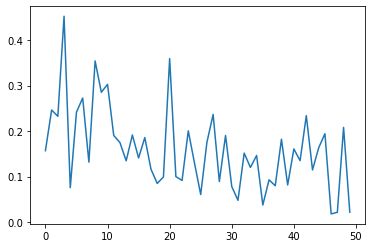

In [85]:
plt.plot(losses)

In [86]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.43714285714285717

### So the model isn't great, but it's better than random selection, so that's something